In [1]:
from MovieRecommend import Movies

In [2]:
mov = Movies()

Loading saved movie database...


In [3]:
mov.print_files()

xander (story), Dougie Brimson (story)...   
334  Peter Benchley (screenplay), Carl Gottlieb (sc...   
335  S.S. Wilson (story), Brent Maddock (story), Ro...   
336    Hossein Amini (screenplay), James Sallis (book)   
337  Robert Hamner (characters), Ron Mita (story), ...   

                                                Actors  \
0    Michelle Williams, Christopher Plummer, Mark W...   
1    Dwayne Johnson, Kevin Hart, Jack Black, Karen ...   
2    Keanu Reeves, Riccardo Scamarcio, Ian McShane,...   
3    Jessica Chastain, Idris Elba, Kevin Costner, M...   
4    Gary Oldman, Kristin Scott Thomas, Ben Mendels...   
..                                                 ...   
333  Elijah Wood, Charlie Hunnam, Claire Forlani, M...   
334  Roy Scheider, Robert Shaw, Richard Dreyfuss, L...   
335  Kevin Bacon, Fred Ward, Finn Carter, Michael G...   
336  Ryan Gosling, Carey Mulligan, Bryan Cranston, ...   
337  Samuel L. Jackson, Colin Farrell, Michelle Rod...   

                         

In [4]:
mov.preview_files()

                            Title  Year  Rated     Released  Runtime  \
0      All the Money in the World  2017      R  25 Dec 2017  132 min   
1  Jumanji: Welcome to the Jungle  2017  PG-13  20 Dec 2017  119 min   
2            John Wick: Chapter 2  2017      R  10 Feb 2017  122 min   
3                    Molly's Game  2017      R  05 Jan 2018  140 min   
4                    Darkest Hour  2017  PG-13  22 Dec 2017  125 min   

                                        Genre        Director  \
0  Biography, Crime, Drama, Mystery, Thriller    Ridley Scott   
1          Action, Adventure, Comedy, Fantasy     Jake Kasdan   
2                     Action, Crime, Thriller  Chad Stahelski   
3                     Biography, Crime, Drama    Aaron Sorkin   
4              Biography, Drama, History, War      Joe Wright   

                                              Writer  \
0  David Scarpa, John Pearson (based on the book ...   
1  Chris McKenna (screenplay by), Erik Sommers (s...   
2  Derek

In [5]:
new_df = mov.get_df()

In [6]:
mov.train_model()

In create features
Writer column cleaned and assigned
Dataframe assigned for features
/home/jake/Documents/VSCode_Projects/MovieRecommend/MovieRecommend.py:93: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  in_df['BoxOffice'] = in_df['BoxOffice'].str.replace('$','')
Plot lemma column created
Form columns split
Created new dataframes of split columns
Joining dataframes
Dataframes joined


In [7]:
mov.preview_files()

                            Title  Year  Rated  Released  Runtime  \
0      All the Money in the World  2017      R  25/12/17    132.0   
1  Jumanji: Welcome to the Jungle  2017  PG-13  20/12/17    119.0   
2            John Wick: Chapter 2  2017      R  10/02/17    122.0   
3                    Molly's Game  2017      R  05/01/18    140.0   
4                    Darkest Hour  2017  PG-13  22/12/17    125.0   

                                          Genre         Director  \
0  [biography, crime, drama, mystery, thriller]    [ridleyscott]   
1          [action, adventure, comedy, fantasy]     [jakekasdan]   
2                     [action, crime, thriller]  [chadstahelski]   
3                     [biography, crime, drama]    [aaronsorkin]   
4              [biography, drama, history, war]      [joewright]   

                                              Writer  \
0                         [davidscarpa, johnpearson]   
1  [chrismckenna, eriksommers, scottrosenberg, je...   
2       

In [8]:
df = mov.get_df()

In [9]:
mov.print_files()

            Jaws  1975     PG  20/06/75    124.0   
335                         Tremors  1990  PG-13  19/01/90     96.0   
336                           Drive  2011      R  16/09/11    100.0   
337                        S.W.A.T.  2003  PG-13  08/08/03    117.0   

                                            Genre              Director  \
0    [biography, crime, drama, mystery, thriller]         [ridleyscott]   
1            [action, adventure, comedy, fantasy]          [jakekasdan]   
2                       [action, crime, thriller]       [chadstahelski]   
3                       [biography, crime, drama]         [aaronsorkin]   
4                [biography, drama, history, war]           [joewright]   
..                                            ...                   ...   
333                    [crime, drama, sport, war]       [lexialexander]   
334                         [adventure, thriller]     [stevenspielberg]   
335                              [comedy, horror]        [r

In [10]:
print(df.columns)

Index(['Title', 'Year', 'Rated', 'Released', 'Runtime', 'Genre', 'Director',
       'Writer', 'Actors', 'Plot', 'Awards', 'Poster', 'Ratings', 'Metascore',
       'imdbRating', 'BoxOffice', 'Production', 'Format', 'Days to View',
       'Days Since Release', 'True Rating', 'Plot Lemma', 'Genre_0', 'Genre_1',
       'Genre_2', 'Genre_3', 'Genre_4', 'Genre_5', 'Genre_6', 'Genre_7',
       'Actors_0', 'Actors_1', 'Actors_2', 'Actors_3', 'Director_0',
       'Director_1', 'Director_2', 'Director_3', 'Production_0',
       'Production_1', 'Production_2', 'Production_3', 'Production_4',
       'Production_5', 'Production_6', 'Production_7', 'Production_8',
       'Production_9', 'Production_10', 'Writer_0', 'Writer_1', 'Writer_2',
       'Writer_3', 'Writer_4', 'Writer_5', 'Writer_6', 'Writer_7', 'Writer_8',
       'Writer_9', 'Writer_10', 'Writer_11', 'Writer_12', 'Writer_13',
       'Writer_14', 'Writer_15'],
      dtype='object')


In [11]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

numerical_cols = ['BoxOffice', 'Metascore', 'Runtime', 'Year', 'imdbRating', 'Days to View', 'Days Since Release']
categorical_cols = ['Rated', 'Format']
#plots = ['Plot']



form_cols = ['Genre', 'Actors', 'Director', 'Production', 'Writer']

for col in form_cols:
    col_str = col + "_"
    in_cols = [col for col in df.columns if col_str in col]
    for col2 in in_cols:
        categorical_cols.append(col2)

print(categorical_cols)
features = numerical_cols + categorical_cols# + plots

for i in features:
    df[i] = df[i].replace('N/A',np.NaN)
    df[i] = df[i].replace('',np.NaN)
    df[i] = df[i].replace(' ',np.NaN)
    df[i] = df[i].replace('missing_value',np.NaN)

numerical_transformer = SimpleImputer(missing_values=np.NaN,
                                      strategy='median')

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(missing_values=np.NaN,
                              strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

tfidf_transformer = TfidfVectorizer()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
        #('tfidf', tfidf_transformer, plots)
    ]
)

x = df[features]
y = df['True Rating']

X_train, X_val, y_train, y_val = train_test_split(x, y, random_state = 0)

print(X_train)

['Rated', 'Format', 'Genre_0', 'Genre_1', 'Genre_2', 'Genre_3', 'Genre_4', 'Genre_5', 'Genre_6', 'Genre_7', 'Actors_0', 'Actors_1', 'Actors_2', 'Actors_3', 'Director_0', 'Director_1', 'Director_2', 'Director_3', 'Production_0', 'Production_1', 'Production_2', 'Production_3', 'Production_4', 'Production_5', 'Production_6', 'Production_7', 'Production_8', 'Production_9', 'Production_10', 'Writer_0', 'Writer_1', 'Writer_2', 'Writer_3', 'Writer_4', 'Writer_5', 'Writer_6', 'Writer_7', 'Writer_8', 'Writer_9', 'Writer_10', 'Writer_11', 'Writer_12', 'Writer_13', 'Writer_14', 'Writer_15']
      BoxOffice Metascore  Runtime  Year  imdbRating  Days to View  \
8    54513740.0        88    115.0  2017         8.1            21   
263   3956031.0        62    107.0  2019         7.0           251   
204         NaN        94    137.0  2019         7.9            38   
124  33080084.0        78    157.0  2007         7.7          4339   
260  82348319.0        52    117.0  2002         6.7          6

In [12]:
from xgboost import XGBRegressor

params = {"n_estimators": [50, 100, 150, 200, 300, 500, 750, 1000],
          "max_features": ['auto', 'sqrt', 'log2'],
          "max_depth": [3, 4, 5],
          "min_child_weight": [1, 2, 5, 10],
          "gamma": [0.5, 1, 1.5, 2, 5],
          "subsample": [0.8, 1.0, 1.2],
          "colsample_bytree": [0.6, 0.8, 1.0]
          }

xgb_model = XGBRegressor(n_estimators=1000,
                         learning_rate=0.05,
                         n_jobs=-2)

grid = GridSearchCV(xgb_model, 
                    param_grid=params,
                    scoring="r2",
                    verbose=2,
                    n_jobs = -3)

#xgb_pipeline = Pipeline(steps=[
#    ('preprocessor', preprocessor),
#    ('model', xgb_model)
#])

grid_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', grid)
])

In [13]:
new_search = False

if new_search:
    grid_pipeline.fit(X_train, y_train)
    good_boys = grid.best_params_
else:
    #no nlp:
    #good_boys = {'colsample_bytree': 0.6, 'gamma': 1.5, 'max_depth': 3, 'max_features': 'auto', 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 1.0}
    # nlp: 
    good_boys = {'colsample_bytree': 0.6, 'gamma': 5, 'max_depth': 3, 'max_features': 'auto', 'min_child_weight': 1, 'n_estimators': 500, 'subsample': 0.8}
    # actual numbers recommend only 50 estimators

In [14]:
print(good_boys)

{'colsample_bytree': 0.6, 'gamma': 5, 'max_depth': 3, 'max_features': 'auto', 'min_child_weight': 1, 'n_estimators': 500, 'subsample': 0.8}


In [15]:
good_boys = {'colsample_bytree': 0.6, 'gamma': 5, 'max_depth': 3, 'max_features': 'auto', 'min_child_weight': 1, 'n_estimators': 500, 'subsample': 0.8}

xgb_model = XGBRegressor(n_estimators=good_boys['n_estimators'],
                         learning_rate=0.05,
                         colsample_bytree=good_boys['colsample_bytree'],
                         gamma=good_boys['gamma'],
                         max_depth=good_boys['max_depth'],
                         max_features=good_boys['max_features'],
                         min_child_weight=good_boys['min_child_weight'],
                         subsample=good_boys['subsample'],
                         n_jobs=-2)

xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', xgb_model)
])

In [16]:
preprocessor.fit(X_train, y_train)

X_train_xfm = preprocessor.fit_transform(X_train)
X_val_xfm = preprocessor.transform(X_val)

xgb_pipeline.fit(X_train, y_train,
                model__early_stopping_rounds=50,
                model__eval_set=[(X_val_xfm, y_val)])

preds = xgb_pipeline.predict(X_val)

score = mean_absolute_error(preds, y_val)
print("MAE: " + str(score))

score2 = mean_squared_error(preds, y_val)
print("MSE: " + str(score2))

[14:26:39] WARNING: ../src/learner.cc:573: 
Parameters: { "max_features" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-rmse:2.62966
[1]	validation_0-rmse:2.58874
[2]	validation_0-rmse:2.55762
[3]	validation_0-rmse:2.51912
[4]	validation_0-rmse:2.49912
[5]	validation_0-rmse:2.47665
[6]	validation_0-rmse:2.46589
[7]	validation_0-rmse:2.44828
[8]	validation_0-rmse:2.42778
[9]	validation_0-rmse:2.40765
[10]	validation_0-rmse:2.39792
[11]	validation_0-rmse:2.39691
[12]	validation_0-rmse:2.38391
[13]	validation_0-rmse:2.37560
[14]	validation_0-rmse:2.36489
[15]	validation_0-rmse:2.36437
[16]	validation_0-rmse:2.35721
[17]	validation_0-rmse:2.35574
[18]	validation_0-rmse:2.35387
[19]	validation_0-rmse:2.35263
[20]	validation_0-rmse:2.34623
[21]	validation_0-rmse:2.

In [17]:
print(new_df['True Rating'])

0      1
1      3
2      3
3      3
4      1
      ..
333    0
334    2
335    3
336    5
337    1
Name: True Rating, Length: 338, dtype: int64


<AxesSubplot:xlabel='True Rating', ylabel='Count'>

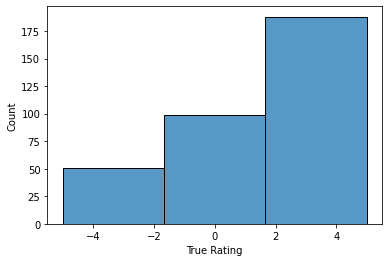

In [18]:
import seaborn as sns

sns.histplot(new_df['True Rating'], bins=3)